# WHAT IS TORCH.NN REALLY?

https://pytorch.org/tutorials/beginner/nn_tutorial.html

- Author: Israel Oliveira [\[e-mail\]](mailto:'Israel%20Oliveira%20'<prof.israel@gmail.com>)

In [1]:
%load_ext watermark
%config Completer.use_jedi = False

In [2]:
import pandas as pd

In [3]:
#import matplotlib.pyplot as plt
#%matplotlib inline
#from IPython.core.pylabtools import figsize
#figsize(12, 8)

#import seaborn as sns
#sns.set_theme()

#pd.set_option("max_columns", None)
#pd.set_option("max_rows", None)

#from IPython.display import Markdown, display
#def md(arg):
#    display(Markdown(arg))

#from pandas_profiling import ProfileReport
# report = ProfileReport(#DataFrame here#, minimal=True)
# report.to

#import pyarrow.parquet as pq
# df = pq.ParquetDataset(path_to_folder_with_parquets, filesystem=None).read_pandas().to_pandas()

In [4]:
# Run this cell before close.
%watermark -d --iversion -b -r -g -m -v
!cat /proc/cpuinfo |grep 'model name'|head -n 1 |sed -e 's/model\ name/CPU/'
!free -h |cut -d'i' -f1  |grep -v total

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.19.0

Compiler    : GCC 8.3.0
OS          : Linux
Release     : 5.8.0-7630-generic
Machine     : x86_64
Processor   : 
CPU cores   : 8
Architecture: 64bit

Git hash: 1a3a825233de5d88c7bbcc4d75a74973a95ee894

Git repo: https://github.com/ysraell/examples.git

Git branch: master

ipywidgets: 7.6.3
pandas    : 1.2.1
json      : 2.0.9
numpy     : 1.19.5
sys       : 3.7.9 (default, Jan 12 2021, 17:26:22) 
[GCC 8.3.0]

CPU	: Intel(R) Xeon(R) CPU E3-1241 v3 @ 3.50GHz
Mem:           31G
Swap:         4.0G


In [6]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [7]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


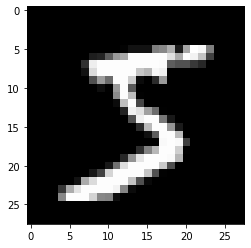

In [8]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [10]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape

print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [11]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

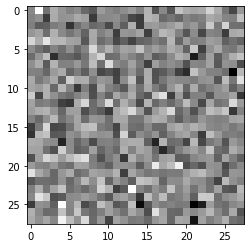

In [15]:
pyplot.imshow(weights[:,1].detach().numpy().reshape((28, 28)), cmap="gray")

In [16]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [24]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
print(preds[0], preds.shape)

tensor([-2.1976, -2.5080, -2.3068, -2.4617, -2.5240, -2.7019, -2.3677, -2.0180,
        -1.6324, -2.9310], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [25]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3232, grad_fn=<NegBackward>)


In [26]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.0469)


In [29]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [30]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0653, grad_fn=<NegBackward>) tensor(1.)


In [32]:
print(accuracy(model(x_valid), y_valid))

tensor(0.9217)


In [35]:
torch.argmax(model(x_valid[0]))

tensor(3)

In [34]:
y_valid[0]

tensor(3)

In [36]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [37]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0653, grad_fn=<NllLossBackward>) tensor(1.)


In [38]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [39]:
model = Mnist_Logistic()

In [41]:
print(loss_func(model(xb), yb))

tensor(2.3393, grad_fn=<NllLossBackward>)


In [42]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [43]:
print(loss_func(model(xb), yb))

tensor(0.0816, grad_fn=<NllLossBackward>)


In [44]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [45]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2518, grad_fn=<NllLossBackward>)


In [46]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0808, grad_fn=<NllLossBackward>)


In [47]:
from torch import optim

In [48]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3219, grad_fn=<NllLossBackward>)
tensor(0.0822, grad_fn=<NllLossBackward>)


In [49]:
from torch.utils.data import TensorDataset

In [50]:
train_ds = TensorDataset(x_train, y_train)

In [52]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0815, grad_fn=<NllLossBackward>)


In [53]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [54]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0804, grad_fn=<NllLossBackward>)


In [55]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [56]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3666)
1 tensor(0.3002)


In [57]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [58]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [59]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [60]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.31163375650644304
1 0.28511213232278826


# Switch to CNN

In [61]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [62]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.7705317485809327
1 0.5712308297634124


In [64]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

def postprocess(x):
    return x.view(x.size(0), -1)

In [65]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(postprocess),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3586811787605286
1 0.25249507484436035


In [66]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [67]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(postprocess),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [68]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33729618515968324
1 0.28614706952571867
